In [1]:
import _plot_functions
import _functions
import matplotlib.pyplot as plt
import periodictable as pt
from periodictable import constants
import numpy as np


# Parameters
# _input = elements_str
_input = 'UGd'  # input('Please input the chemicals? ')
thick_mm = 1  # input('Please input the thickness in mm : ')
_input_density = 0.7875  # g/cm3  not needed if _input is single element
_database = 'ENDF_VIII'
energy_max = 300  # max incident energy in eV
energy_min = 0  # min incident energy in eV
energy_sub = 100
sub_x = energy_sub * (energy_max - energy_min)  # subdivided new x-axis
# _multi_element = 'N'
_energy_x_axis = 'Y'  # 1 means plot x-axis as energy in eV
_trans_y_axis = 'N'  # 1 means plot y-axis as transmission
_plot_each_ele_contribution = 'Y'  # 1 means plot each element's contribution
_plot_each_iso_contribution = 'N'  # 1 means plot each isotope's contribution
_plot_mixed = 'N'  # 1 means plot mixed resonance

In [2]:
formula_dict = _functions.input2formula(_input)  # Function called to parse input formula and return elements and ratios
elements = _functions.dict_key_list(formula_dict)
ratios = _functions.dict_value_list(formula_dict)
all_ele_boo_dict = _functions.boo_dict(elements)  # Dict for natural mixture
thick_boo_dict = _functions.boo_dict(elements)  # Dict for same thickness
thick_mm_dict = _functions.thick_dict(elements, thick_mm)


# For unnatural mixture elements:
_unnatural_ele_input = input('Is there any unnatural mixture? ')
if _unnatural_ele_input == 'Y':
    unnatural_ratio_dicts = {}
    unnatural_element_str = input('Please list all separated by only " ": ')
    unnatural_element = unnatural_element_str.split(' ')
    all_ele_boo_dict = _functions.boo_dict_invert_by_key(unnatural_element, all_ele_boo_dict)
    isotope_dict = _functions.get_isotope_dict(_database, unnatural_element)
    print(isotope_dict)
    for ele in unnatural_element:
        isotopes = isotope_dict[ele]
        unnatural_ratio_dict = {}
        for iso in isotopes:
            unnatural_ratio_dict[iso] = float(input('Atomic ratio of {} in mixture: '.format(iso)))
        unnatural_ratio_dicts[ele] = unnatural_ratio_dict
    # print(unnatural_ratio_dicts)

# For sample with various thickness:
_thick_input = input('Is there any element with different thickness? ')
if _thick_input == 'Y':
    resize_element_str = input('Please list all separated by only " ": ')
    resize_element = resize_element_str.split(' ')
    all_ele_boo_dict = _functions.boo_dict_invert_by_key(resize_element, thick_boo_dict)
    for ele in resize_element:
        thick_mm_dict[ele] = float(input('Thickness of {} in mm: '.format(ele)))
print(thick_mm_dict)


if len(elements) == 1:
    sample_density = pt.elements.isotope(_input).density  # g/cm3  https://en.wikipedia.org/wiki/Cadmium
else:
    # _input_density = 0.7875  # g/cm3  need to input while the _input is multi-element mixture
    sample_density = _input_density  # input('Please input the density in g/cm3 : ')

Parsed chemical formula: {'U': 1, 'Gd': 1}
Is there any unnatural mixture? N
Is there any element with different thickness? N
{'U': 1, 'Gd': 1}


In [3]:
mass_iso_ele_dict = {}  # For number of atoms per cm3 calculation
y_i_iso_ele_dicts = {}  # For transmission calculation at isotope lever
y_i_iso_ele_sum_dict = {}  # For transmission calculation at element lever
df_raw_dict = {}  # Raw sigma data for elements and isotopes
isotopes_dict = {}  # List all isotopes for each element involved
abundance_dicts = {}  # List all natural abundance for each isotope of each element involved
all_ratio_dicts = {}
# unnatural_ratio_dicts = _functions.empty_dict(elements)  # empty with value of 1 no meaning
for _each_ in elements:
    _element = _each_
    ele_at_ratio = formula_dict[_each_] / sum(ratios)
    # Get pre info (isotopes, abundance, mass, density) of each element from the formula
    isotopes_dict[_each_], all_ratio_dicts[_each_], iso_abundance, iso_density, iso_mass, abundance_dict, density_dict, mass_dict, file_names = \
        _plot_functions.get_pre_data(_database, _element)

    if _unnatural_ele_input == 'Y':
        if _each_ in unnatural_ratio_dicts:
            all_ratio_dicts[_each_] = unnatural_ratio_dicts[_each_]

    mass_iso_ele_dict[_each_] = _plot_functions.get_mass_iso_ele(iso_abundance, iso_mass, ele_at_ratio,
                                                                 all_ele_boo_dict[_each_],
                                                                 all_ratio_dicts[_each_])

    x_energy, y_i_iso_ele_dict, y_i_iso_ele_sum, df_raw_dict[_each_] = \
        _plot_functions.get_xy(isotopes_dict[_each_], file_names, energy_min, energy_max, iso_abundance,
                               sub_x, ele_at_ratio, all_ele_boo_dict[_each_], all_ratio_dicts[_each_])
    y_i_iso_ele_dicts[_each_] = y_i_iso_ele_dict
    y_i_iso_ele_sum_dict[_each_] = y_i_iso_ele_sum

print('Abundance_dicts: ', all_ratio_dicts)
# print(mass_iso_ele_dict)
# print(ele_at_ratio)

mass_iso_ele_list = list(dict.values(mass_iso_ele_dict))
mass_iso_ele_sum = sum(np.array(mass_iso_ele_list))
mixed_atoms_per_cm3 = sample_density * pt.constants.avogadro_number/mass_iso_ele_sum
# Use function: mixed_atoms_per_cm3 = _functions.atoms_per_cm3(density=sample_density, mass=mass_iso_ele_sum)

keys = list(dict.keys(y_i_iso_ele_sum_dict))
yi_values = list(dict.values(y_i_iso_ele_sum_dict))
yi_values_sum = sum(yi_values)
trans_sum = _functions.sig2trans_quick(thick_mm, mixed_atoms_per_cm3, yi_values_sum)
y_trans_tot = trans_sum
# print(y_i_iso_ele_sum_dict)

Abundance_dicts:  {'U': {'233-U': 0.0, '234-U': 5.4999999999999995e-05, '235-U': 0.0072, '238-U': 0.992745}, 'Gd': {'152-Gd': 0.002, '154-Gd': 0.0218, '155-Gd': 0.14800000000000002, '156-Gd': 0.2047, '157-Gd': 0.1565, '158-Gd': 0.2484, '160-Gd': 0.2186}}


In [4]:
### Create the trans or absorb dict of ele for plotting if needed
if _plot_each_ele_contribution == 'Y':
    y_ele_dict = {}
    for _ele in elements:
        if _trans_y_axis == 'Y':
            y_ele_dict[_ele] = _functions.sig2trans_quick(thick_mm, mixed_atoms_per_cm3, y_i_iso_ele_sum_dict[_ele])
        else:
            y_ele_dict[_ele] = 1 - _functions.sig2trans_quick(thick_mm, mixed_atoms_per_cm3, y_i_iso_ele_sum_dict[_ele])

### Create the trans or absorb dict : y_iso_dicts of isotopes for plotting if needed
if _plot_each_iso_contribution == 'Y':
    y_iso_dicts = {}
    y_iso_dict = {}
    for _ele in elements:
        for _iso in isotopes_dict[_ele]:
            if _trans_y_axis == 'Y':
                y_iso_dict[_iso] = _functions.sig2trans_quick(thick_mm, mixed_atoms_per_cm3,
                                                              y_i_iso_ele_dicts[_ele][_iso])
            else:
                y_iso_dict[_iso] = 1 - _functions.sig2trans_quick(thick_mm, mixed_atoms_per_cm3,
                                                                  y_i_iso_ele_dicts[_ele][_iso])
        y_iso_dicts[_ele] = y_iso_dict
        y_iso_dict = {}  # Clear for following set of isotopes
    # print(y_iso_dicts)

In [5]:
### Determine x y axis types and captions
if _energy_x_axis == 'Y':
    _x_axis = x_energy
    _x_words = 'Energy (eV)'
else:
    _x_axis = _functions.ev2lamda(x_energy)
    _x_words = 'Wavelength (Å)'

if _trans_y_axis == 'Y':
    _y_words = 'Neutron transmission'
else:
    _y_words = 'Neutron attenuation'

### Determine x y axis values
if _plot_mixed == 'Y':
    if _trans_y_axis == 'Y':
        _y_axis = y_trans_tot
    else:
        _y_axis = 1 - y_trans_tot
    plt.plot(_x_axis, _y_axis, label=_input)

if _plot_each_ele_contribution == 'Y':
    for _ele in elements:
        _y_each_axis = y_ele_dict[_ele]
        plt.plot(_x_axis, _y_each_axis, label=_ele)

if _plot_each_iso_contribution == 'Y':
    for _ele in elements:
        for _iso in isotopes_dict[_ele]:
            _y_each_axis = y_iso_dicts[_ele][_iso]
            plt.plot(_x_axis, _y_each_axis, label=_iso)

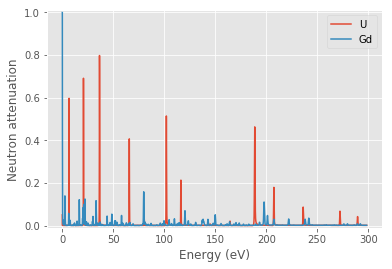

In [6]:
plt.ylim(-0.01, 1.01)
plt.xlabel(_x_words)
plt.ylabel(_y_words)
plt.legend(loc='best')
plt.show()